In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
#import matplotlib

import pandas as pd
import numpy as np
import durationpy
import math
from os.path import join
from collections import defaultdict


In [2]:
plt.style.use('ggplot')

COLORS_DEFAULT ={'blue': '#348ABD', 'red': '#E24A33'}

In [3]:
# conda install -c phlya adjusttext 
from adjustText import adjust_text

## csv result files directory name and file names

In [4]:
CSV_RESULT_DIR = "../benchmark_results_data"

STANDALONE_WASM_RESULT_FILE = "standalone_wasm_results.csv"
NATIVE_RESULT_FILE = "native_benchmarks.csv"
SCOUT_RESULT_FILE = "scout_bignum_benchmarks.csv"





## To add a new engine, add the engine name used in the csv file to this list

In [5]:
INTERPRETER_ENGINES = ['life', 'wagon', 'wasmi', 'wabt', 'v8-interpreter', 'wasm3', 'wamr-interp', 'fizzy']
COMPILER_ENGINES = ['lifePolymerase', 'wasmtime', 'wavm', 'v8-liftoff', 'v8-turbofan', 'asmble', 'wamr-jit', 'wamr-aot']

wasm_vm_names = INTERPRETER_ENGINES + COMPILER_ENGINES

## Helper funcs

In [6]:
def toMs(secs):
    if secs < 0.001:
        μs = secs * 1000000
        return "{}μs".format(round(μs, 1))
    if secs < 0.1:
        ms = secs * 1000
        return "{}ms".format(round(ms, 1))
    elif secs < 1:
        ms = secs * 1000
        return "{}ms".format(int(round(ms, 0)))
    else:
        return "{}s".format(round(secs, 2))

In [7]:
def labelBarHeights(ax, to_ms=True, small=False, to_factor=False, lower_y_bound=True):
    labels = []
    for p in ax.patches:
        if p.get_height() == 0:
            continue
        label_val = p.get_height()
        #print("height:", p.get_height())
        y_pos = p.get_y() + label_val
        #y_offset = -10
        y_offset = 0
        y_bound = ax.get_ybound()[1]
        if y_pos > y_bound:
            y_pos = y_bound
        #if label_val < (0.03 * y_bound):
            # if bar is too small to fit text, place above the bar
            #y_offset = 5
        if lower_y_bound:
            if label_val < (0.03 * y_bound) and small is False:
                # don't place labels near bottom axis, adjust_text cant deal
                y_offset = 0.03 * y_bound
        
        if label_val > 1000:
            label_val = int(label_val)
        if to_ms:
            label_val = toMs(label_val)
        if to_factor:
            if not isinstance(to_factor, int):
                to_factor = 2
            label_val = str(round(label_val, to_factor)) + "x"
        """
        txt_label = ax.annotate(toMs(label_val),
                    (p.get_x()+p.get_width()/2.,
                     y_pos),
                    ha='center',
                    va='center',
                    xytext=(0, y_offset),
                    textcoords='offset points',
                    fontsize=10,
                    weight="bold")
        """
 
        txt_label = ax.text(
                    x=p.get_x()+p.get_width()/2.,
                    y=y_pos+y_offset,
                    s=label_val,
                    ha='center',
                    va='center',
                    #xytext=(0, y_offset),
                    #textcoords='offset points',
                    fontsize=10,
                    weight="bold")

        labels.append(txt_label)

    #adjust_text(labels, ax=ax)
    return labels

In [8]:
def labelBarWidths(ax, to_ms=True, to_factor=False, to_kb=False, round_places=None):
    for p in ax.patches:
        label_val = p.get_width()
        if label_val == 0:
            continue
        #print("bar width:", label_val)
        x_pos = p.get_x() + label_val
        x_offset = -30
        x_bound = ax.get_xbound()[1]
        if (x_pos > x_bound):
            x_pos = x_bound
        #if label_val < (0.25 * x_bound):
        if label_val < (0.15 * x_bound):
            # if bar is too small to fit text, place next to bar
            x_offset = 30
        if label_val > 1000:
            label_val = int(label_val)
        if to_ms:
            label_val = toMs(label_val)
        if to_factor:
            label_val = str(round(label_val, 2)) + "x"
        if to_kb:
            kbs = label_val / 1000.0
            label_val = str(round(kbs, 1)) + " kB"
        if round_places:
            label_val = str(round(label_val, round_places))
        ax.annotate(label_val,
                    (x_pos,
                     p.get_y()+p.get_height()/2.),
                    ha='center',
                    va='center',
                    xytext=(x_offset, 0),
                    textcoords='offset points',
                    fontsize=10,
                    weight="bold")


In [9]:
def adjust_text_labels(labels, ax=None):
    adjust_text(labels, ax=ax, autoalign='y', only_move={'points':'y', 'text':'y'})
                       

In [10]:
def read_results(file_name):
    results = defaultdict(list)
    csv_results = pd.read_csv(file_name)    
    return csv_results

In [11]:
def filterDfEngines(df_data, engines):
    df_data_filtered = df_data.copy()
    for fil in engines:
        df_data_filtered = df_data_filtered[df_data_filtered['engine'] != fil]

    return df_data_filtered

## print benchmark machine cpu type

In [12]:
with open(join(CSV_RESULT_DIR, "cpuinfo.txt"), 'r') as cpuinfofile:
    [print(line.rstrip()) for line in cpuinfofile.readlines()]


model name	: Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz
cpu MHz		: 2294.685
model name	: Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz
cpu MHz		: 2294.685
model name	: Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz
cpu MHz		: 2294.685
model name	: Intel(R) Xeon(R) CPU E5-2673 v4 @ 2.30GHz
cpu MHz		: 2294.685


### Import scout engine results

In [13]:
df_scout_data = read_results(join(CSV_RESULT_DIR, SCOUT_RESULT_FILE))

## functions for plotting a two engine comparison

In [14]:
## we aren't using this chart style anymore. replaced by plotThreeTestsGrouped()
def plotTwoEngines(df_benches, two_engines, title="Title"):
    df_1 = df_benches[df_benches['engine'] == two_engines[0]]
    df_2 = df_benches[df_benches['engine'] == two_engines[1]]
    plt.figure()
    f, (ax1) = plt.subplots(1, 2, sharey=True, figsize=(13,6))

    df_1.set_index('bench_name').sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[0], color=COLORS_DEFAULT['blue'])
    ax1[0].set_title(two_engines[0])
    ax1[0].set(ylabel='seconds', xlabel='')
    df_2.set_index('bench_name').sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[1], color=COLORS_DEFAULT['blue'])
    ax1[1].set_title(two_engines[1])
    ax1[1].set(xlabel='')
    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    f.suptitle(title, fontsize=16, y=0.98)
    plt.show()


#df_sha256_1024 = df_scout_data[df_scout_data['bench_name'].str.contains('sha256_1024')]
#df_blake2b_64 = df_scout_data[df_scout_data['bench_name'].str.contains('blake2b_64')]
#plotTwoEngines(df_sha256_1024, ["wabt-baseline", "wabt-with-superops"], "sha256 1024 bytes")
#plotTwoEngines(df_blake2b_64, ["wabt-baseline", "wabt-with-superops"], "blake2b 64 bytes")

In [15]:
def plotThreeTestsGrouped(df_benches, three_tests, title="Title"):
    df_1 = df_benches[df_benches['bench_name'].str.contains(three_tests[0])]
    df_2 = df_benches[df_benches['bench_name'].str.contains(three_tests[1])]
    df_3 = df_benches[df_benches['bench_name'].str.contains(three_tests[2])]
    # to group by engine, pivot to `columns='enginge'`
    df_1 = pd.pivot_table(df_1, values='exec_time', columns=['engine'], index=['bench_name'], aggfunc=np.mean)
    df_2 = pd.pivot_table(df_2, values='exec_time', columns=['engine'], index=['bench_name'], aggfunc=np.mean)
    df_3 = pd.pivot_table(df_3, values='exec_time', columns=['engine'], index=['bench_name'], aggfunc=np.mean)

    plt.figure()
    f, (ax1) = plt.subplots(1, 3, sharey=True, figsize=(13,6))

    df_1.sort_values('wabt-with-superops').plot.bar(ax=ax1[0])
    ax1[0].set_title(three_tests[0])
    ax1[0].set(ylabel='seconds', xlabel='')

    df_2.sort_values('wabt-with-superops').plot.bar(ax=ax1[1])
    ax1[1].set_title(three_tests[1])
    ax1[1].set(xlabel='')

    df_3.sort_values('wabt-with-superops').plot.bar(ax=ax1[2])
    ax1[2].set_title(three_tests[2])
    ax1[2].set(xlabel='')

    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    adjust_text_labels(labelBarHeights(ax1[2]), ax=ax1[2])

    f.suptitle(title, fontsize=16, y=0.98)
    plt.show()


## Compare wabt-optimized against wabt-baseline on hash function benchmarks

<Figure size 432x288 with 0 Axes>

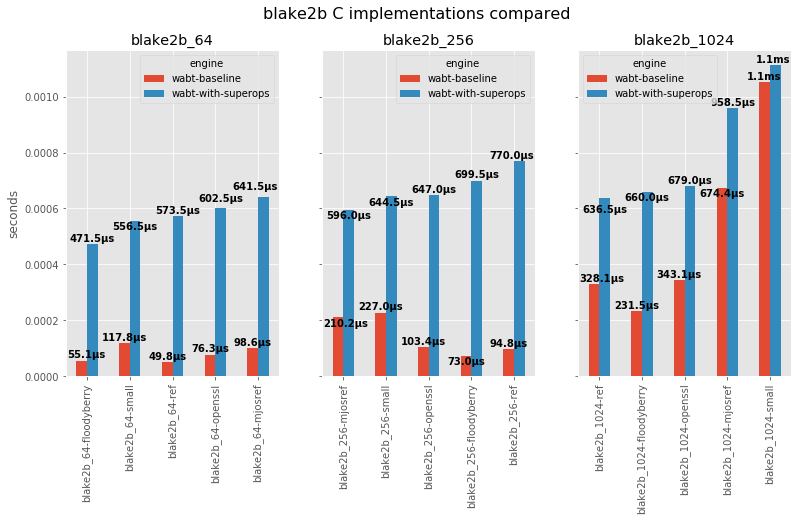

In [16]:
plotThreeTestsGrouped(df_scout_data, ["blake2b_64", "blake2b_256", "blake2b_1024"], "blake2b C implementations compared")


<Figure size 432x288 with 0 Axes>

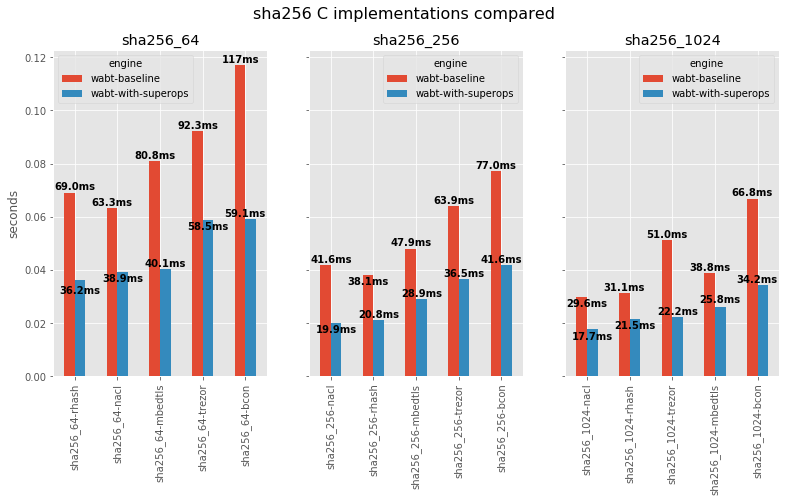

In [17]:
plotThreeTestsGrouped(df_scout_data, ["sha256_64", "sha256_256", "sha256_1024"], "sha256 C implementations compared")


<Figure size 432x288 with 0 Axes>

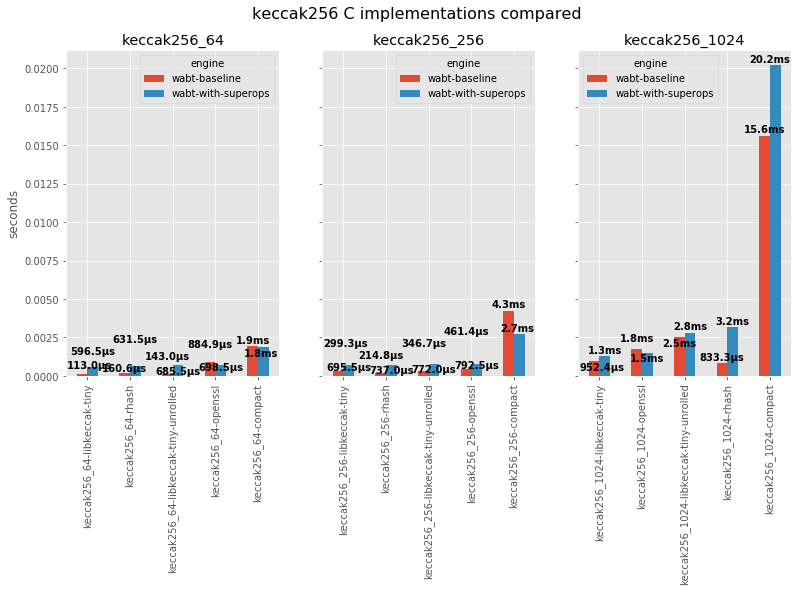

In [18]:
plotThreeTestsGrouped(df_scout_data, ["keccak256_64", "keccak256_256", "keccak256_1024"], "keccak256 C implementations compared")


## functions for plotting biturbo and bignum benchmarks

In [19]:
# non-stacked bar chart, for only plotting exec time or total time
def plotOneTest(df_data, suptitle="title", suptitle_pos=1.00, subtitle="subchart", subtitle_size='medium'):
    plt.figure()
    df_total_times = df_data[['exec_time', 'parse_time']].copy()
    df_total_times.fillna(0, inplace=True)
    df_total_times['time'] = df_total_times['exec_time'] + df_total_times['parse_time']
    ax = df_total_times.sort_values('time')[['time']].plot.bar(figsize=(14,8), color=COLORS_DEFAULT['blue'])
    # fontsize = {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    ax.set_title(subtitle, fontsize=subtitle_size)
    ax.set(ylabel="seconds", xlabel="")
    ax.xaxis.set_tick_params(labelrotation=60, labelsize=12)
    adjust_text_labels(labelBarHeights(ax))
    plt.suptitle(suptitle, fontsize=18, y=suptitle_pos)
    plt.show()


In [20]:
def plotScoutStackedTest(df_data, suptitle="title", suptitle_pos=1.00, subtitle="subchart", subtitle_size='medium'):
    plt.figure()
    # for some reason, exec_time needs to come first for the stacked chart to display correctly
    ax = df_data[['exec_time', 'parse_time']].sort_values('exec_time').plot.bar(stacked=True, color=[COLORS_DEFAULT['blue'], COLORS_DEFAULT['red']], figsize=(10,10))
    # fontsize = {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
    ax.set_title(subtitle, fontsize=subtitle_size)
    ax.set(ylabel="seconds", xlabel="")
    df_total_times = df_data[['exec_time', 'parse_time']].copy()
    df_total_times['total_time'] = df_total_times['exec_time'] + df_total_times['parse_time']
    ax.xaxis.set_tick_params(labelrotation=60, labelsize=12)
    adjust_text_labels(labelBarHeights(ax, lower_y_bound=False))
    ax.legend(labels=["execution time", "startup time"])
    plt.suptitle(suptitle, fontsize=18, y=suptitle_pos)
    plt.show()


## Plot biturbo benchmark: biturbo-token-eth1-mainnet-stateless-block-hexary-trie-keccak256-multiproof

In [21]:
df_scout_biturbo_token = df_scout_data[df_scout_data['bench_name'] == 'biturbo-token-eth1-mainnet-stateless-block-hexary-trie-keccak256-multiproof']

df_scout_means_biturbo_token = df_scout_biturbo_token.groupby(['engine']).mean()
df_scout_fast_biturbo_token = filterDfEngines(df_scout_biturbo_token, ['v8-interpreter'])
df_scout_fast_biturbo_means = df_scout_fast_biturbo_token.groupby(['engine']).mean()



<Figure size 432x288 with 0 Axes>

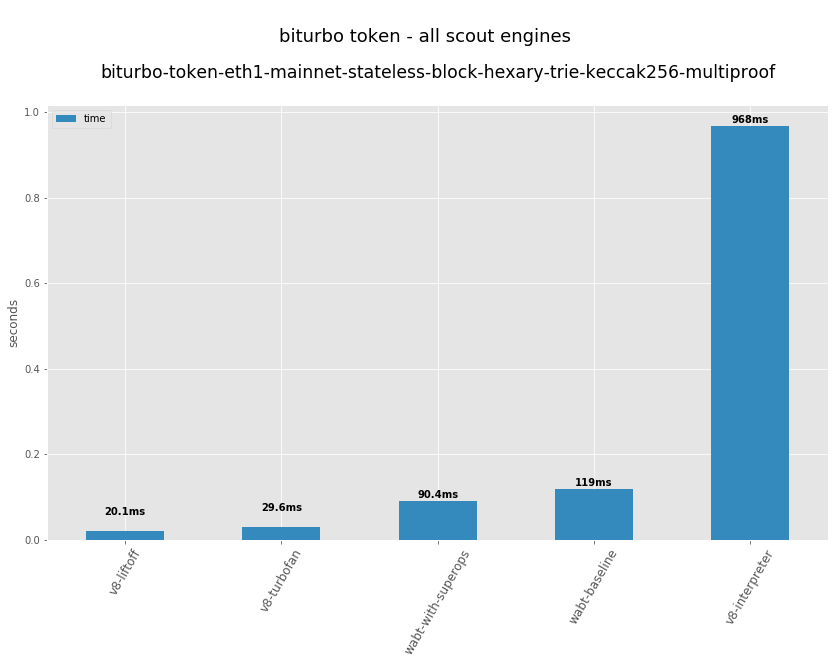

In [22]:
plotOneTest(df_scout_means_biturbo_token,
            suptitle="\nbiturbo token - all scout engines",
            suptitle_pos=1.05,
            subtitle="biturbo-token-eth1-mainnet-stateless-block-hexary-trie-keccak256-multiproof\n",
            subtitle_size='xx-large')

<Figure size 432x288 with 0 Axes>

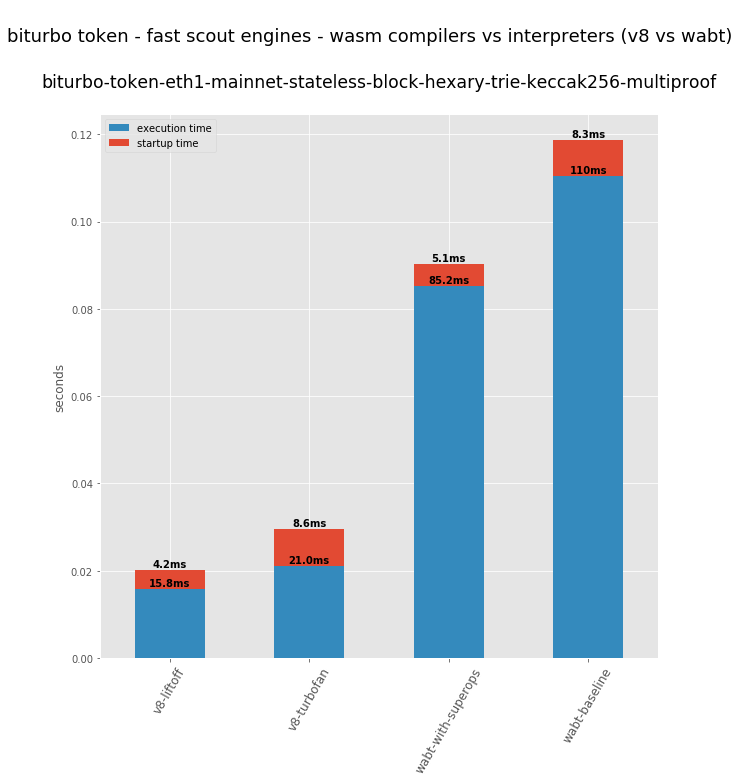

In [23]:
plotScoutStackedTest(df_scout_fast_biturbo_means,
            suptitle="\nbiturbo token - fast scout engines - wasm compilers vs interpreters (v8 vs wabt)",
            suptitle_pos=1.03,
            subtitle="biturbo-token-eth1-mainnet-stateless-block-hexary-trie-keccak256-multiproof\n",
            subtitle_size='xx-large')

## Plot bignum benchmark: ecrecover-eth1-txns-websnark-secp256k1-verify-72-sigs

In [24]:
df_scout_ecrecover_websnark_secp256k1 = df_scout_data[df_scout_data['bench_name'] == 'ecrecover-eth1-txns-websnark-secp256k1-verify-72-sigs']

df_scout_means_ecrecover_websnark_secp256k1 = df_scout_ecrecover_websnark_secp256k1.groupby(['engine']).mean()
df_scout_fast_ecrecover = filterDfEngines(df_scout_ecrecover_websnark_secp256k1,
    ['v8-interpreter', 'scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])
df_scout_fast_ecrecover_means = df_scout_fast_ecrecover.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

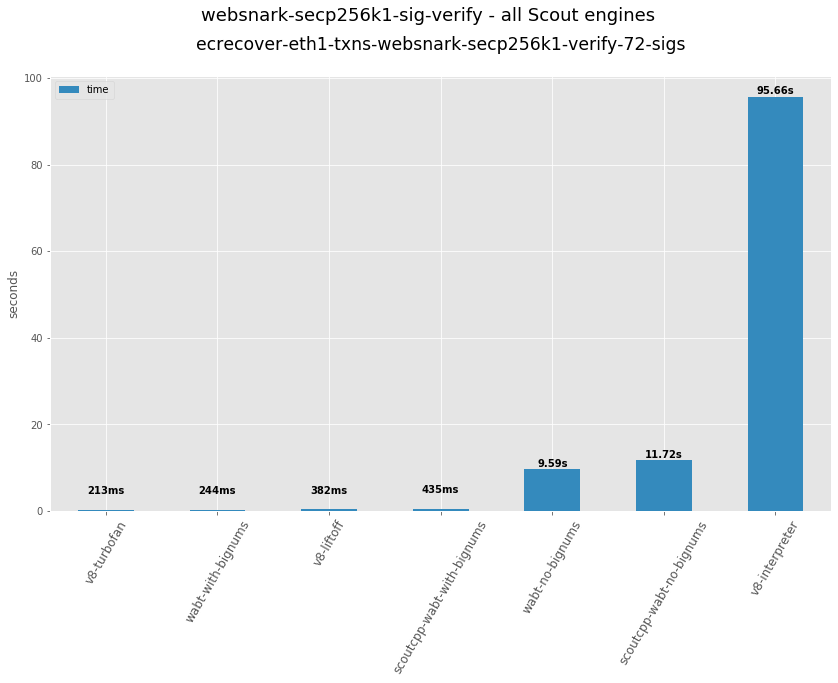

In [25]:
plotOneTest(df_scout_means_ecrecover_websnark_secp256k1,
            suptitle="websnark-secp256k1-sig-verify - all Scout engines",
            suptitle_pos=1.0,
            subtitle="ecrecover-eth1-txns-websnark-secp256k1-verify-72-sigs\n",
            subtitle_size='xx-large')

<Figure size 432x288 with 0 Axes>

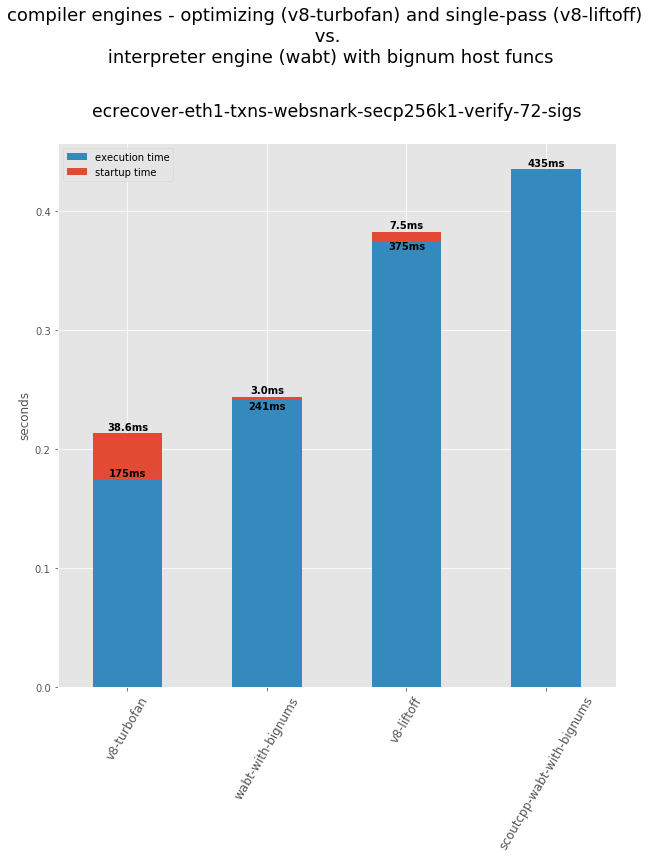

In [26]:
plotScoutStackedTest(df_scout_fast_ecrecover_means,
            #suptitle="websnark-secp256k1-sig-verify - fast Scout engines - compilers (v8) vs interpreters (wabt)",
            suptitle="compiler engines - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n interpreter engine (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="ecrecover-eth1-txns-websnark-secp256k1-verify-72-sigs\n",
            subtitle_size='xx-large')

## Plot bignum benchmark: ecpairing-zkrollup-websnark-bn128-two-pairings

In [27]:
df_scout_ecpairing_zkrollup_bn128_pairings = df_scout_data[df_scout_data['bench_name'] == 'ecpairing-zkrollup-websnark-bn128-two-pairings']

df_scout_means_ecpairing_zkrollup = df_scout_ecpairing_zkrollup_bn128_pairings.groupby(['engine']).mean()
df_scout_fast_ecpairing_zkrollup = filterDfEngines(df_scout_ecpairing_zkrollup_bn128_pairings,
    ['v8-interpreter', 'scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])
df_scout_fast_means_ecpairing_zkrollup = df_scout_fast_ecpairing_zkrollup.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

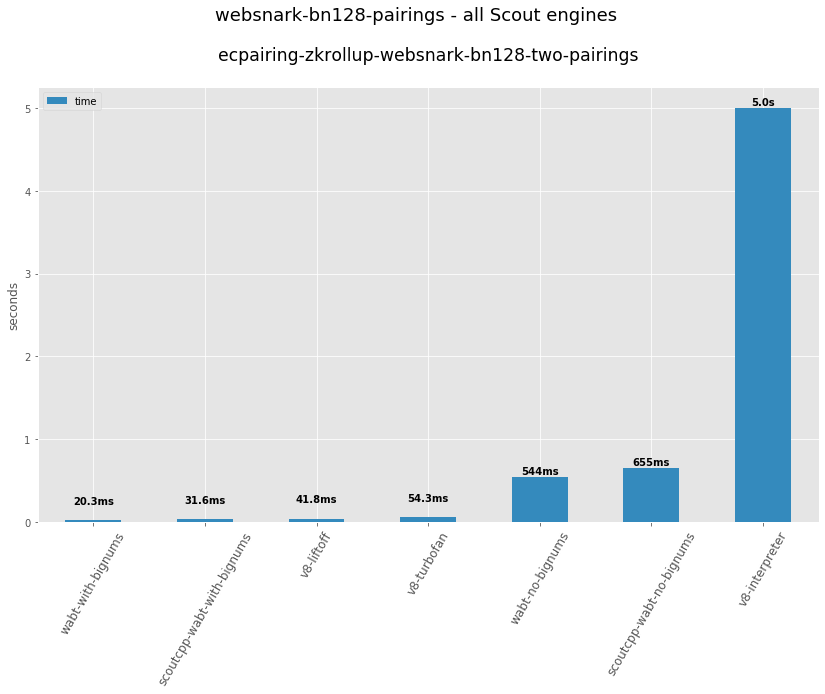

In [28]:
plotOneTest(df_scout_means_ecpairing_zkrollup,
            suptitle="websnark-bn128-pairings - all Scout engines",
            suptitle_pos=1.02,
            subtitle="ecpairing-zkrollup-websnark-bn128-two-pairings\n",
            subtitle_size='xx-large')

<Figure size 432x288 with 0 Axes>

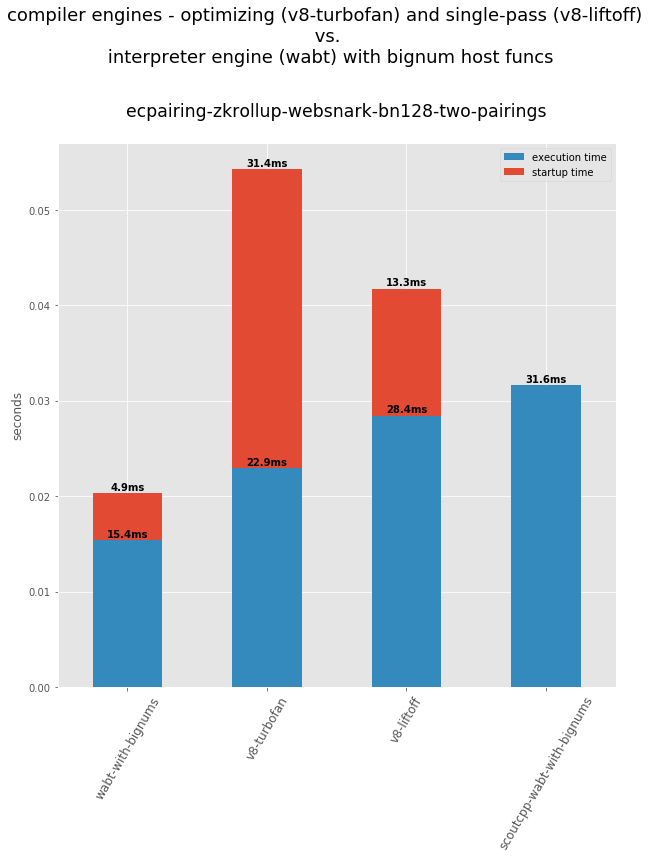

In [29]:
plotScoutStackedTest(df_scout_fast_means_ecpairing_zkrollup,
            suptitle="compiler engines - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n interpreter engine (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="ecpairing-zkrollup-websnark-bn128-two-pairings\n",
            subtitle_size='xx-large')

## Plot bignum benchmark: daiquiri-zkmixer-websnark-bn128-groth16-four-pairings-and-mimc

In [30]:
df_scout_daiquiri_zkmixer = df_scout_data[df_scout_data['bench_name'] == 'daiquiri-zkmixer-websnark-bn128-groth16-four-pairings-and-mimc']

df_scout_means_daiquiri_zkmixer = df_scout_daiquiri_zkmixer.groupby(['engine']).mean()
df_scout_fast_daiquiri_zkmixer = filterDfEngines(df_scout_daiquiri_zkmixer,
    ['v8-interpreter', 'scoutcpp-wabt-no-bignums', 'wabt-no-bignums'])
df_scout_fast_means_daiquiri_zkmixer = df_scout_fast_daiquiri_zkmixer.groupby(['engine']).mean()


<Figure size 432x288 with 0 Axes>

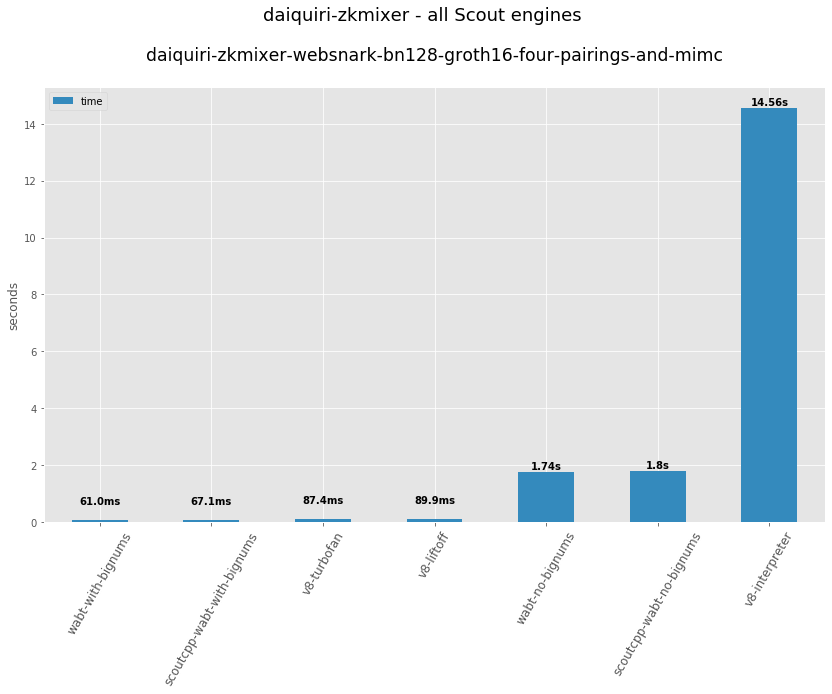

In [31]:
plotOneTest(df_scout_means_daiquiri_zkmixer,
            suptitle="daiquiri-zkmixer - all Scout engines",
            suptitle_pos=1.02,
            subtitle="daiquiri-zkmixer-websnark-bn128-groth16-four-pairings-and-mimc\n",
            subtitle_size='xx-large')

<Figure size 432x288 with 0 Axes>

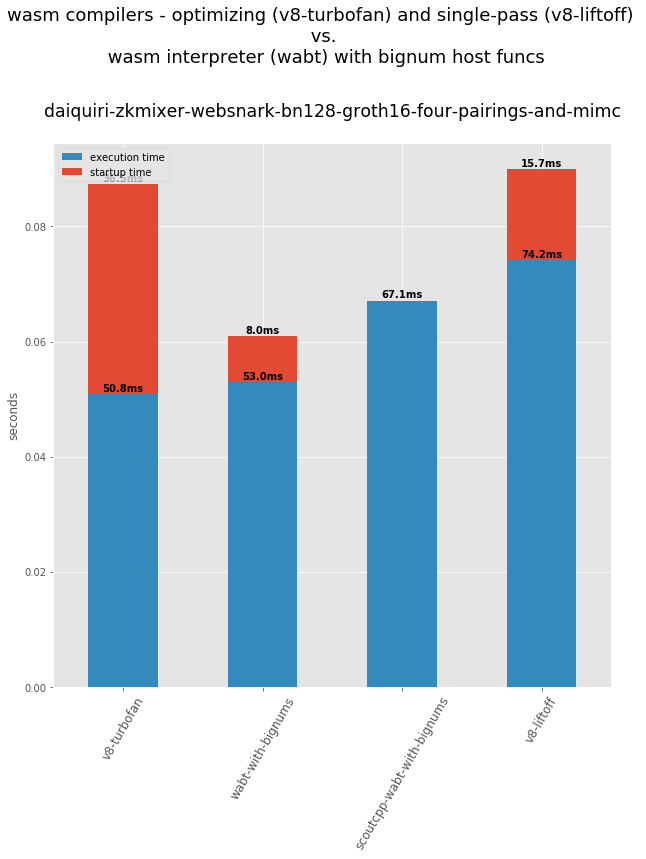

In [32]:
plotScoutStackedTest(df_scout_fast_means_daiquiri_zkmixer,
            suptitle="wasm compilers - optimizing (v8-turbofan) and single-pass (v8-liftoff) \n vs. \n wasm interpreter (wabt) with bignum host funcs",
            suptitle_pos=1.07,
            subtitle="daiquiri-zkmixer-websnark-bn128-groth16-four-pairings-and-mimc\n",
            subtitle_size='xx-large')

### Import standalone wasm results

In [33]:
df_wasm = read_results(join(CSV_RESULT_DIR, STANDALONE_WASM_RESULT_FILE))

In [34]:
df_wasm

,engine,test_name,elapsed_time,compile_time,exec_time
0,wagon,bn128_mul-chfast2,0.480003,0.209461,0.138601
1,wagon,bn128_mul-chfast2,0.309776,0.172602,0.132262
2,wagon,bn128_mul-chfast2,0.348052,0.191159,0.149208
3,wagon,bn128_mul-chfast2,0.316315,0.184961,0.124199
4,wagon,bn128_mul-chfast2,0.358139,0.182283,0.170218
...,...,...,...,...,...
13935,fizzy,bn128_add-cdetrio14,2.519304,0.000051,0.000640
13936,fizzy,bn128_add-cdetrio14,2.660058,0.000056,0.000706
13937,fizzy,bn128_add-cdetrio14,2.770020,0.000058,0.001055
13938,fizzy,bn128_add-cdetrio14,2.748923,0.000053,0.000682


### Import native results

In [35]:
df_native_raw = read_results(join(CSV_RESULT_DIR, NATIVE_RESULT_FILE))

In [36]:
native_results = {}
for i in range(len(df_native_raw)):
    test_name = df_native_raw['test_name'][i]
    native_results[test_name] = df_native_raw['elapsed_times'][i].split(', ')

    
test_names = df_native_raw['test_name'].tolist()

native_times = {}
for test in test_names:
    avg = np.mean([float(t) for t in native_results[test]])
    native_times[test] = avg

    
df_native = pd.DataFrame.from_dict(native_times, orient='index', columns=['elapsed_time'])
df_native['engine'] = 'rust-native'

In [37]:
df_native

,elapsed_time,engine
blake2b-8415-bytes,0.000026,rust-native
blake2b-5610-bytes,0.000012,rust-native
blake2b-2805-bytes,0.000008,rust-native
bls12-381-aggreg-128-pubkeys-verify-sig,0.027138,rust-native
bls12-381-aggreg-64-pubkeys-verify-sig,0.028107,rust-native
bls12-381-aggreg-32-pubkeys-verify-sig,0.024123,rust-native
bn128_pairing-ten_point_match_1,0.021701,rust-native
bn128_pairing-one_point,0.006033,rust-native
bn128_pairing-two_point_match_2,0.010407,rust-native
sha1-10808-bits,0.000007,rust-native


### sorted lists of test names for plotting inputs in order

In [38]:
blake2b_test_names = [name for name in df_wasm['test_name'].unique().tolist() if 'blake2b' in name]
blake2b_test_names.sort()
blake2b_test_names_desc = blake2b_test_names.copy()
blake2b_test_names_desc.reverse()


In [39]:
sha1_test_names = [name for name in df_wasm['test_name'].unique().tolist() if 'sha1' in name]
sha1_test_names.sort()
sha1_test_names_desc = sha1_test_names.copy()
sha1_test_names_desc.reverse()


In [40]:

bn128_mul_test_names = ['bn128_mul-cdetrio11', 'bn128_mul-chfast2', 'bn128_mul-chfast1']
bn128_add_test_names = ['bn128_add-cdetrio11', 'bn128_add-cdetrio14', 'bn128_add-cdetrio10']
bn128_pairing_test_names = ['bn128_pairing-ten_point_match_1', 'bn128_pairing-two_point_match_2', 'bn128_pairing-one_point']

bn128_mul_test_names.reverse()
bn128_add_test_names.reverse()
bn128_pairing_test_names.reverse()

bn128_mul_test_names_desc = ['bn128_mul-cdetrio11', 'bn128_mul-chfast2', 'bn128_mul-chfast1']
bn128_add_test_names_desc = ['bn128_add-cdetrio11', 'bn128_add-cdetrio14', 'bn128_add-cdetrio10']
bn128_pairing_test_names_desc = ['bn128_pairing-ten_point_match_1', 'bn128_pairing-two_point_match_2', 'bn128_pairing-one_point']



In [41]:
bls12_test_names = ['bls12-381-aggreg-32-pubkeys-verify-sig', 'bls12-381-aggreg-64-pubkeys-verify-sig', 'bls12-381-aggreg-128-pubkeys-verify-sig']
bls12_test_names_desc = bls12_test_names.copy()
bls12_test_names_desc.reverse()

In [42]:
modexp_test_names = [name for name in df_wasm['test_name'].unique().tolist() if 'modexp' in name]
modexp_test_names.sort()
modexp_test_names_desc = modexp_test_names.copy()
modexp_test_names_desc.reverse()

In [43]:
all_tests = sha1_test_names + blake2b_test_names + modexp_test_names + ['ed25519-verify-ten-inputs'] + bls12_test_names \
    + bn128_add_test_names + bn128_mul_test_names + bn128_pairing_test_names

### Prepare interpreter dataframe

In [44]:
all_interp_test_names = []

interp_results_for_df = []
for engine in INTERPRETER_ENGINES:
    df_engine = df_wasm[df_wasm['engine'] == engine]
    df_means = df_engine.groupby(['test_name']).mean()
    test_names = df_engine['test_name'].unique().tolist()
    all_interp_test_names.extend(test_names)
    for test_name in test_names:
        interp_results_for_df.append([engine, test_name] + df_means.loc[test_name].tolist())

        
all_interp_test_names = set(all_interp_test_names)

#interp_results_for_df

df_interp = pd.DataFrame(interp_results_for_df)
df_interp.columns = ['engine', 'test_name', 'elapsed_time', 'parse_time', 'exec_time']
df_interp.set_index('engine', inplace=True)
df_interp['total_time'] = df_interp['parse_time'] + df_interp['exec_time']
#df_interp

In [45]:
df_wasm['test_name'].unique().tolist()

['bn128_mul-chfast2',
 'bn128_add-cdetrio11',
 'sha1-42488-bits',
 'bn128_mul-chfast3',
 'bn128_mul-cdetrio11',
 'sha1-10808-bits',
 'bn128_pairing-ten_point_match_1',
 'modexp-nagydani-1-square',
 'bn128_pairing-one_point',
 'bn128_mul-cdetrio12',
 'bls12-381-aggreg-128-pubkeys-verify-sig',
 'modexp-nagydani-1-qube',
 'ed25519-verify-ten-inputs',
 'bls12-381-aggreg-64-pubkeys-verify-sig',
 'blake2b-5610-bytes',
 'bn128_add-cdetrio10',
 'bn128_mul-cdetrio6',
 'bn128_mul-cdetrio7',
 'modexp-eip_example1',
 'bn128_pairing-two_point_match_2',
 'bn128_mul-chfast1',
 'bls12-381-aggreg-32-pubkeys-verify-sig',
 'blake2b-2805-bytes',
 'sha1-21896-bits',
 'bn128_mul-cdetrio2',
 'blake2b-8415-bytes',
 'bn128_add-cdetrio14']

## Interpreter engines compared

In [46]:
def plotInterpThreeTests(df_testdata, three_names, title="Title", filter_engines=None):
    if filter_engines is not None:
        df_testdata = filterDfEngines(df_testdata.reset_index(), filter_engines)
        df_testdata.set_index('engine', inplace=True)
    df_1 = df_testdata[df_testdata['test_name'] == three_names[0]]
    df_2 = df_testdata[df_testdata['test_name'] == three_names[1]]
    df_3 = df_testdata[df_testdata['test_name'] == three_names[2]]
    plt.figure()
    f, (ax1) = plt.subplots(1, 3, sharey=True, figsize=(16,7))
    df_1.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[0], stacked=True)
    ax1[0].set_title(three_names[0])
    ax1[0].set(xlabel='')
    df_2.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[1], stacked=True)
    ax1[1].set_title(three_names[1])
    ax1[1].set(xlabel='')
    df_3.sort_values('total_time')[['parse_time', 'exec_time']].plot.bar(ax=ax1[2], stacked=True)
    ax1[2].set_title(three_names[2])
    ax1[2].set(xlabel='')
    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    adjust_text_labels(labelBarHeights(ax1[2]), ax=ax1[2])
    ax1[0].legend(labels=["startup time", "execution time"])
    ax1[1].legend(labels=["startup time", "execution time"])
    ax1[2].legend(labels=["startup time", "execution time"])

    ax1[1].tick_params(axis='y', left=True, labelleft=True)
    ax1[2].tick_params(axis='y', left=True, labelleft=True)
    
    scale_y = 1e-3
    ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
    ax1[1].yaxis.set_major_formatter(ticks_y)
    
    ax1[0].set(ylabel='milliseconds')
    
    f.suptitle(title, fontsize=16, y=0.98)
    plt.show()

<Figure size 432x288 with 0 Axes>

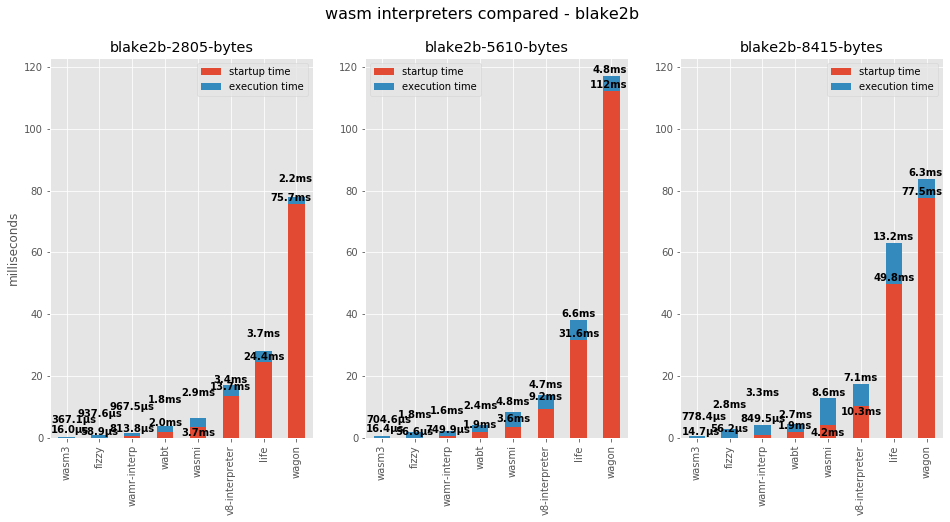

In [47]:
plotInterpThreeTests(df_interp, blake2b_test_names, title="wasm interpreters compared - blake2b")

### Interpreters - Execution time

In [48]:
def plotThreeTestsExecTime(df_testdata, three_names, title="Title", filter_engines=None):
    if filter_engines is not None:
        df_testdata = filterDfEngines(df_testdata.reset_index(), filter_engines)
        df_testdata.set_index('engine', inplace=True)
    df_1 = df_testdata[df_testdata['test_name'] == three_names[0]]
    df_2 = df_testdata[df_testdata['test_name'] == three_names[1]]
    df_3 = df_testdata[df_testdata['test_name'] == three_names[2]]
    plt.figure()
    f, (ax1) = plt.subplots(1, 3, sharey=True, figsize=(16,7))
    df_1.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[0], color=COLORS_DEFAULT['blue'])
    ax1[0].set_title(three_names[0])
    ax1[0].set(xlabel='')
    df_2.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[1], color=COLORS_DEFAULT['blue'])
    ax1[1].set_title(three_names[1])
    ax1[1].set(xlabel='')
    df_3.sort_values('exec_time')[['exec_time']].plot.bar(ax=ax1[2], color=COLORS_DEFAULT['blue'])
    ax1[2].set_title(three_names[2])
    ax1[2].set(xlabel='')
    adjust_text_labels(labelBarHeights(ax1[0]), ax=ax1[0])
    adjust_text_labels(labelBarHeights(ax1[1]), ax=ax1[1])
    adjust_text_labels(labelBarHeights(ax1[2]), ax=ax1[2])
    ax1[0].legend(labels=["execution time"])
    ax1[1].legend(labels=["execution time"])
    ax1[2].legend(labels=["execution time"])

    ax1[1].tick_params(axis='y', left=True, labelleft=True)
    ax1[2].tick_params(axis='y', left=True, labelleft=True)
   
    scale_y = 1e-3
    ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y/scale_y))
    ax1[1].yaxis.set_major_formatter(ticks_y)
    
    ax1[0].set(ylabel='milliseconds')
    
    f.suptitle(title, fontsize=16, y=0.98)
    plt.show()


<Figure size 432x288 with 0 Axes>

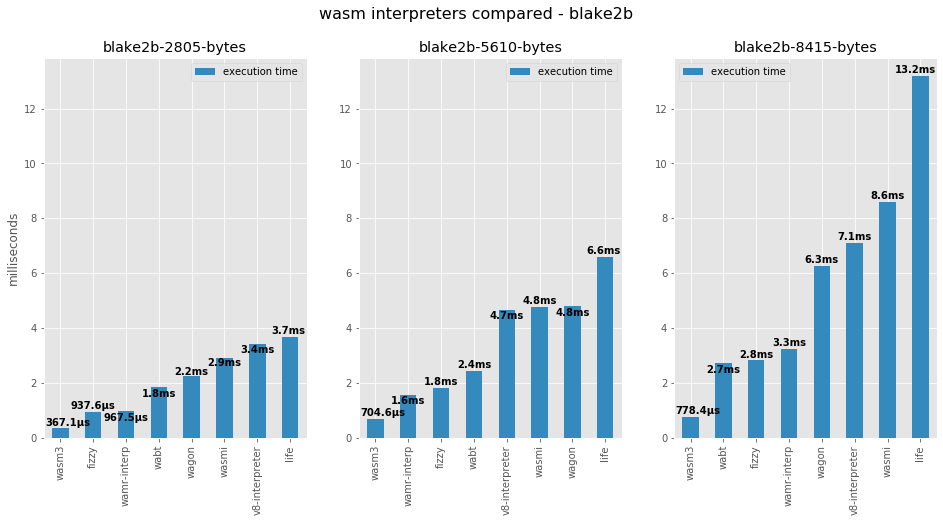

In [49]:
plotThreeTestsExecTime(df_interp, blake2b_test_names, title="wasm interpreters compared - blake2b")

## Chart of only the fast interpreters

<Figure size 432x288 with 0 Axes>

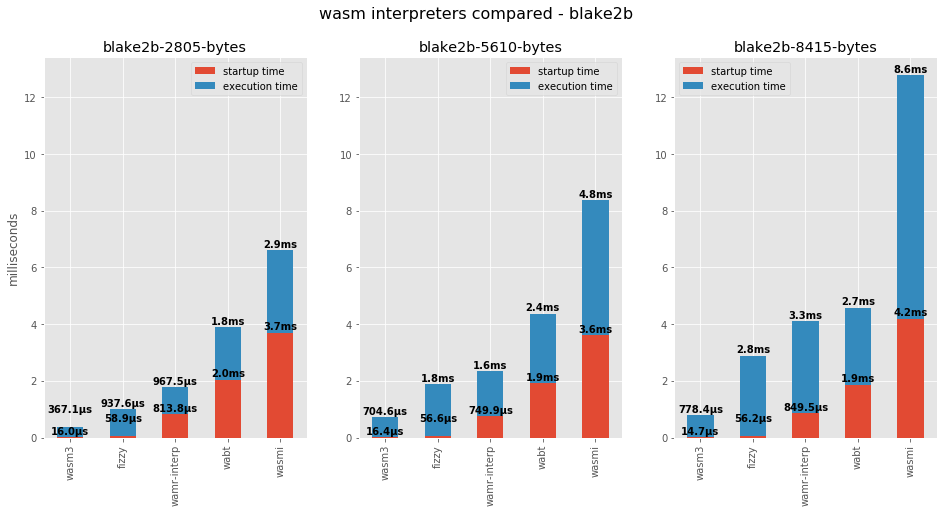

In [50]:
plotInterpThreeTests(df_interp,
                     blake2b_test_names,
                     title="wasm interpreters compared - blake2b",
                     filter_engines=["life", "wagon", "v8-interpreter"])

<Figure size 432x288 with 0 Axes>

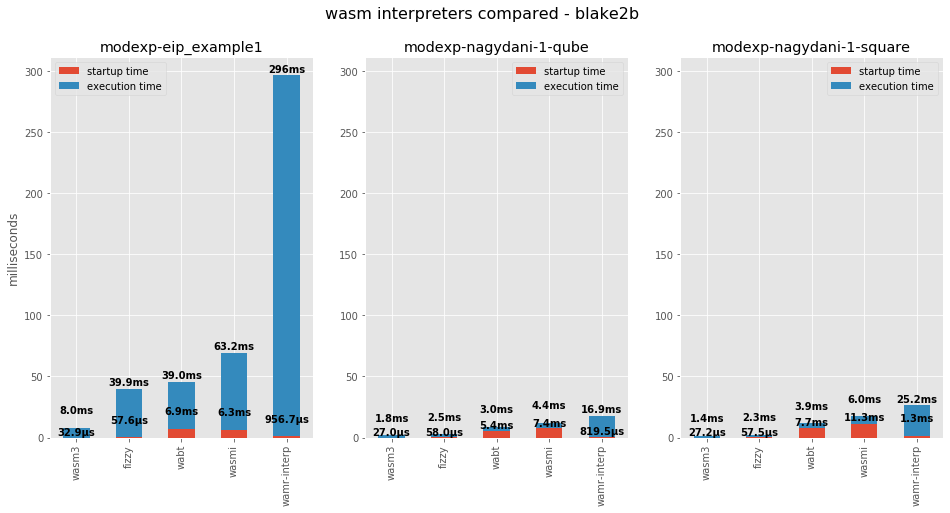

In [51]:
plotInterpThreeTests(df_interp,
                     modexp_test_names,
                     title="wasm interpreters compared - blake2b",
                     filter_engines=["life", "wagon", "v8-interpreter"])

<Figure size 432x288 with 0 Axes>

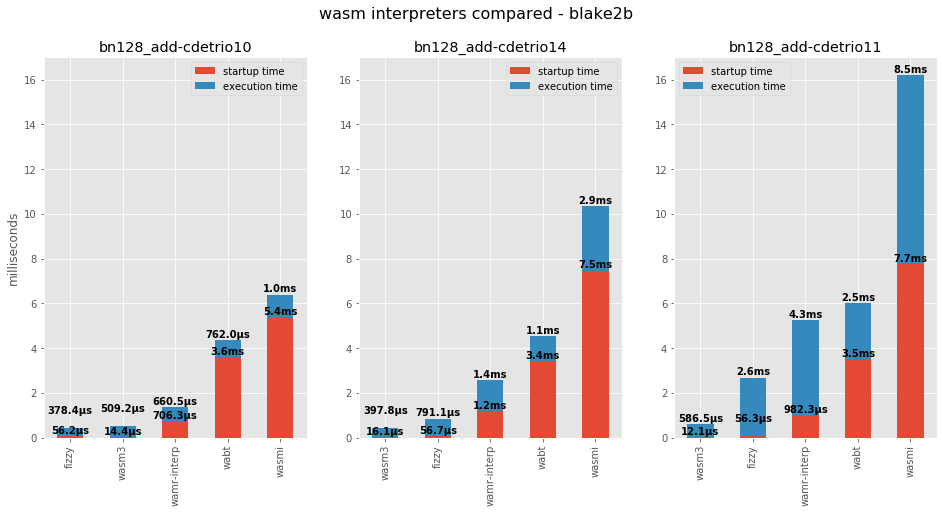

In [52]:
plotInterpThreeTests(df_interp,
                     bn128_add_test_names,
                     title="wasm interpreters compared - blake2b",
                     filter_engines=["life", "wagon", "v8-interpreter"])

<Figure size 432x288 with 0 Axes>

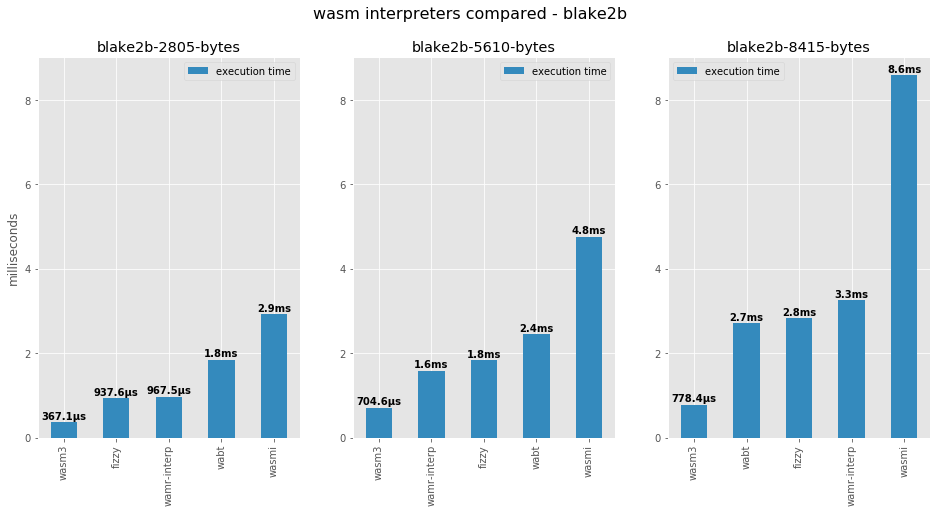

In [53]:
plotThreeTestsExecTime(df_interp,
                       blake2b_test_names,
                       title="wasm interpreters compared - blake2b",
                       filter_engines=["life", "wagon", "v8-interpreter"])

<Figure size 432x288 with 0 Axes>

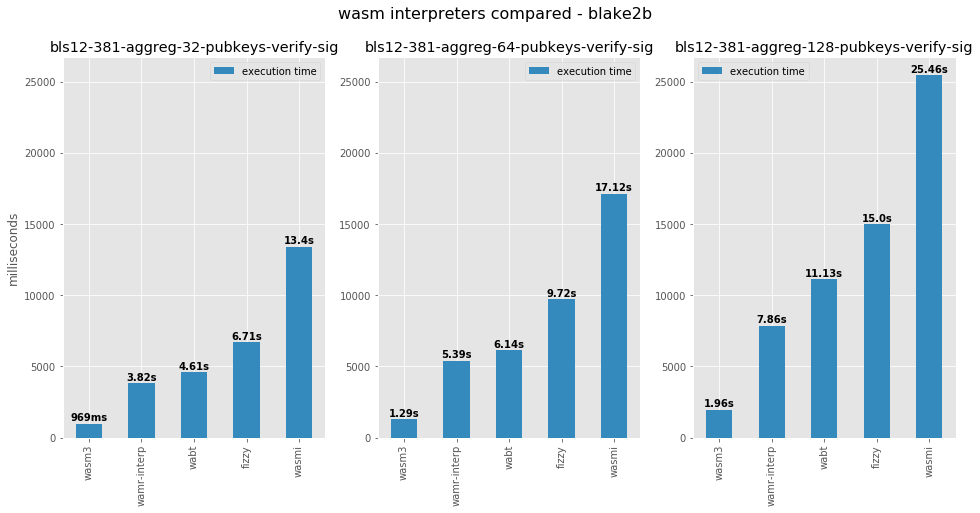

In [54]:
plotThreeTestsExecTime(df_interp,
                       bls12_test_names,
                       title="wasm interpreters compared - blake2b",
                       filter_engines=["life", "wagon", "v8-interpreter"])

## Compiler Results

In [55]:
compiler_results_for_df = []
for engine in COMPILER_ENGINES:
    df_engine = df_wasm[df_wasm['engine'] == engine]
    df_means = df_engine.groupby(['test_name']).mean()
    test_names = df_engine['test_name'].unique().tolist()
    for test_name in test_names:
        compiler_results_for_df.append([engine, test_name] + df_means.loc[test_name].tolist())




In [56]:
df_compiler = pd.DataFrame(compiler_results_for_df)

df_compiler.columns = ['engine', 'test_name', 'elapsed_time', 'compile_time', 'exec_time']
df_compiler.set_index('engine', inplace=True)
df_compiler['total_time'] = df_compiler['compile_time'] + df_compiler['exec_time']

#df_compiler

## Compiler function

*Note: Fix scale for v8-turbofan execution time*

In [57]:
def plotCompilerStackedOneTest(df_benchdata, test_name):
    df_1 = df_benchdata[df_benchdata['test_name'] == test_name]
    # for some reason, exec_time needs to come first for the stacked chart to display correctly
    ax = df_1[['exec_time', 'compile_time']].sort_values('exec_time').plot.bar(stacked=True, color=[COLORS_DEFAULT['blue'], COLORS_DEFAULT['red']], figsize=(10,10))
    ax.set_title("Compilers - {}".format(test_name))
    df_total_times = df_1[['exec_time', 'compile_time']].copy()
    df_total_times['total_time'] = df_total_times['exec_time'] + df_total_times['compile_time']
    ymax = max(df_total_times[['total_time']].max()) * 1.3 # 30% larger for padding between top of bars and top of graph
    ymin = min([x for x in df_1[['exec_time', 'compile_time']].min().tolist() if x > 0])
    ymin = ymin * 0.8 # 0.8 to get a number 20% smaller, fix to make bar appear for smallest exec time
    ax.set_ylim(ymin, ymax)
    ax.set_yscale("log")
    plt.ylabel("seconds (log scale)")
    adjust_text_labels(labelBarHeights(ax, lower_y_bound=False))
    ax.legend(labels=["execution time", "compile time"])
    plt.savefig("../images/wasm-compilers.png")



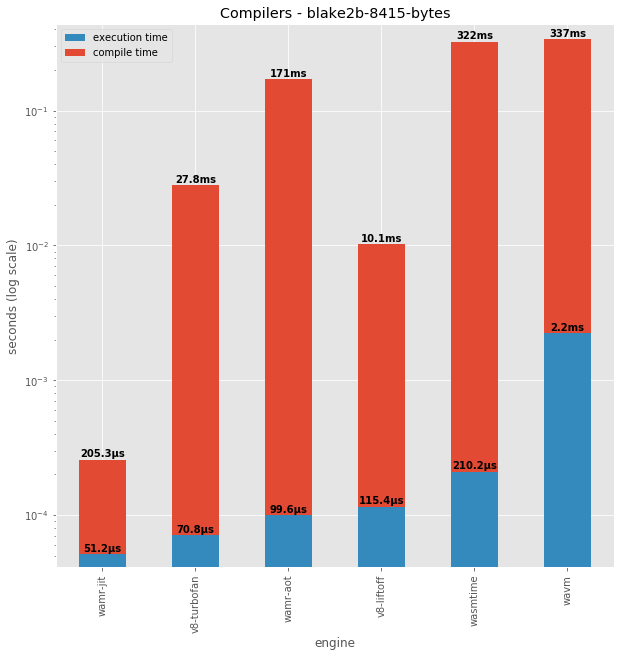

In [58]:
plotCompilerStackedOneTest(df_compiler, blake2b_test_names[2])

In [59]:
def plotCompilerStackedOneTest(df_benchdata, test_name):
    df_1 = df_benchdata[df_benchdata['test_name'] == test_name]
    # for some reason, exec_time needs to come first for the stacked chart to display correctly
    ax = df_1[['exec_time', 'compile_time']].sort_values('exec_time').plot.bar(stacked=True, color=[COLORS_DEFAULT['blue'], COLORS_DEFAULT['red']], figsize=(10,10))
    ax.set_title("Compilers - {}".format(test_name))
    df_total_times = df_1[['exec_time', 'compile_time']].copy()
    df_total_times['total_time'] = df_total_times['exec_time'] + df_total_times['compile_time']
    ymax = max(df_total_times[['total_time']].max()) * 1.3 # 30% larger for padding between top of bars and top of graph
    ymin = min([x for x in df_1[['exec_time', 'compile_time']].min().tolist() if x > 0])
    ymin = ymin * 0.8 # 0.8 to get a number 20% smaller, fix to make bar appear for smallest exec time
    ax.set_ylim(ymin, ymax)
    ax.set_yscale("log")
    plt.ylabel("seconds (log scale)")
    adjust_text_labels(labelBarHeights(ax, lower_y_bound=False))
    ax.legend(labels=["execution time", "compile time"])
    plt.savefig("../images/wasm-compilers.png")


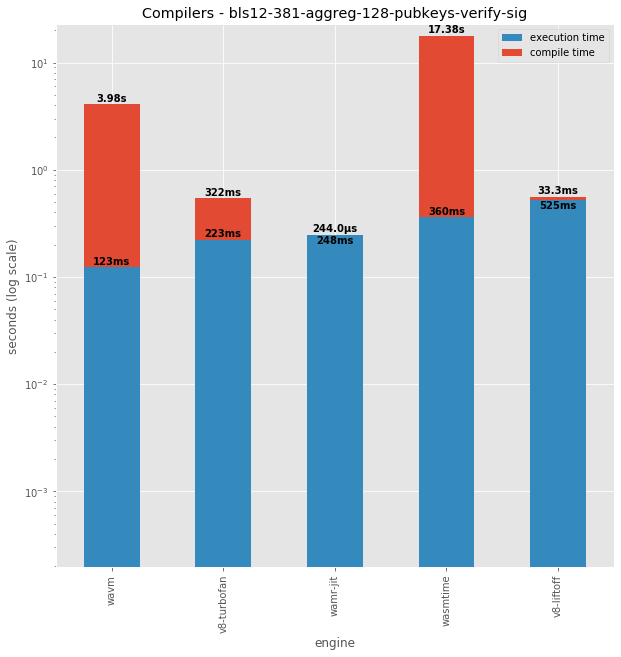

In [60]:
plotCompilerStackedOneTest(df_compiler, "bls12-381-aggreg-128-pubkeys-verify-sig")

## Add rust-native to compiler engines chart

In [61]:
# merge df_native and df_compiler into one dataframe
# both dataframes must have same columns to merge them:
# engine, test_name, elapsed_time, compile_time, exec_time, total_time

df_native_merge = df_native.copy()
df_native_merge.reset_index(inplace=True)
df_native_merge.columns = ['test_name', 'elapsed_time', 'engine']
df_native_merge['compile_time'] = 0
df_native_merge['exec_time'] = df_native_merge['elapsed_time']
df_native_merge['total_time'] = df_native_merge['elapsed_time']
df_native_and_compile = pd.concat([df_compiler.reset_index(), df_native_merge], sort=False)
df_native_and_compile.reset_index(drop=True, inplace=True)
df_native_and_compile.set_index('engine', inplace=True)


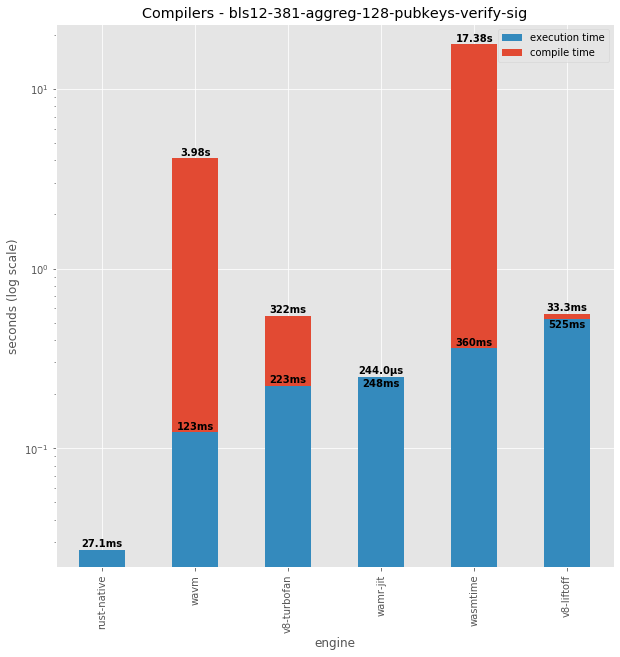

In [62]:
plotCompilerStackedOneTest(df_native_and_compile, "bls12-381-aggreg-128-pubkeys-verify-sig")

## Interpreter vs Compiler speedup

In [63]:
# merge df_compiler and df_interp
df_interp_merge = df_interp.copy()
df_interp_merge.columns = ['test_name', 'elapsed_time', 'compile_time', 'exec_time', 'total_time']
df_interp_and_compile = pd.concat([df_interp_merge, df_compiler])
df_interp_and_compile = df_interp_and_compile.reset_index()

In [64]:
def add_engine_ratio_col(df_two_engines, interp_engine, compiler_engine):
    df_two = df_two_engines.copy(deep=True)
    df_interp = df_two[df_two['engine'] == interp_engine].copy()
    df_compile = df_two[df_two['engine'] == compiler_engine]
    for index, row in df_interp.iterrows():
        test_name = row['test_name']
        row_compiler = df_compile[df_compile['test_name'] == test_name]
        if len(row_compiler) != 1:
            print("ERROR. SHOULD HAVE 1 MATCH ONLY")
            break
        compiler_exec_time = row_compiler.iloc[0]['exec_time']
        exec_ratio = row['exec_time'] / compiler_exec_time
        df_interp.at[index, 'compiler_exec_time'] = compiler_exec_time
        df_interp.at[index, 'interp_slowdown'] = exec_ratio

    return df_interp

In [65]:
df_wabt_v8liftoff = add_engine_ratio_col(df_interp_and_compile, "wabt", "v8-liftoff")

In [66]:
def plotCompilerSpeedup(df_compiler_speedup, interp_name="interp", compiler_name="compiler"):
    df_is = df_compiler_speedup.copy()
    plot_tests = df_is['test_name'].tolist()
    test_index = all_tests.copy()
    for test_name in all_tests:
        if test_name not in plot_tests:
            test_index.remove(test_name)
 
    df_is = df_is.set_index('test_name')
    df_is = df_is.reindex(test_index)
    plt.figure()
    ax = df_is['interp_slowdown'].plot.bar(figsize=(13,7), color=COLORS_DEFAULT['blue'])
    ax.set_title("{} (Interpreter) vs {} (Compiler) - speedup".format(interp_name, compiler_name))
    ax.set(ylabel="compiler speedup (log scale)", xlabel="")

    y_max = ax.get_ylim()[1]
    y_max = y_max * 5 # padding between top of bars and legend
    ax.set_yscale('log')
    ax.set_ylim(0.1, y_max) # adjustment to move horizontal line higher on chart

    adjust_text_labels(labelBarHeights(ax, to_ms=False, to_factor=1, lower_y_bound=False))

    plt.axhline(y=1.0, linewidth=2, ls='--', color='r')

    handles, _ = ax.get_legend_handles_labels()

    plt.legend(labels=["compiler engine is faster (ratio > 1x)", "compiler speedup \n (ratio: interp_exec_time/compiler_exec_time)"])

    #f.suptitle(title, fontsize=16, y=0.95)
    plt.show()


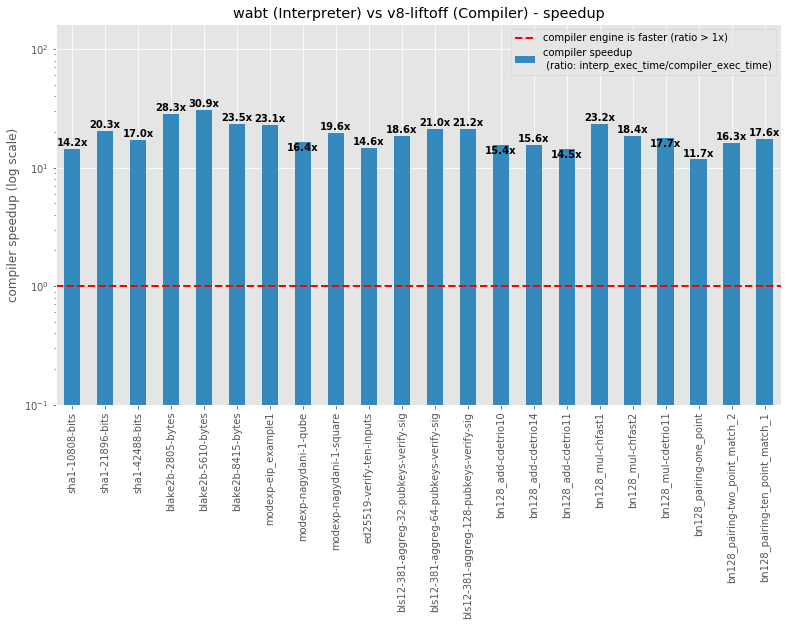

In [67]:
plotCompilerSpeedup(df_wabt_v8liftoff, interp_name="wabt", compiler_name="v8-liftoff")

## All precompiles compared (are interpreters feasible?)

In [68]:
def plotInterpOneEngine(df_benchdata, engine, test_names, title=""):
    df_bench = df_benchdata.loc[engine][df_benchdata.loc[engine]['test_name'].isin(test_names)]
    df_bench.set_index('test_name', inplace=True)
    df_bench = df_bench.reindex(test_names)
    plt.figure()
    ax = df_bench[['parse_time', 'exec_time']].plot.bar(stacked=True, figsize=(15,7), color=[COLORS_DEFAULT['red'], COLORS_DEFAULT['blue']])
    plt.ylabel("seconds")
    ax.set(xlabel='')
    # doing get_legend_handles_labels() so we can control the order of the labels in the legend 
    handles, labels = ax.get_legend_handles_labels()
    plt.legend([handles[1], handles[0]], ['execution time (top bar/label)', 'startup time (bottom bar/label - bar not visible for times < 20.0ms)'])
    adjust_text_labels(labelBarHeights(ax))
    plt.suptitle(title, fontsize=16, y=0.95)
    plt.show()

<Figure size 432x288 with 0 Axes>

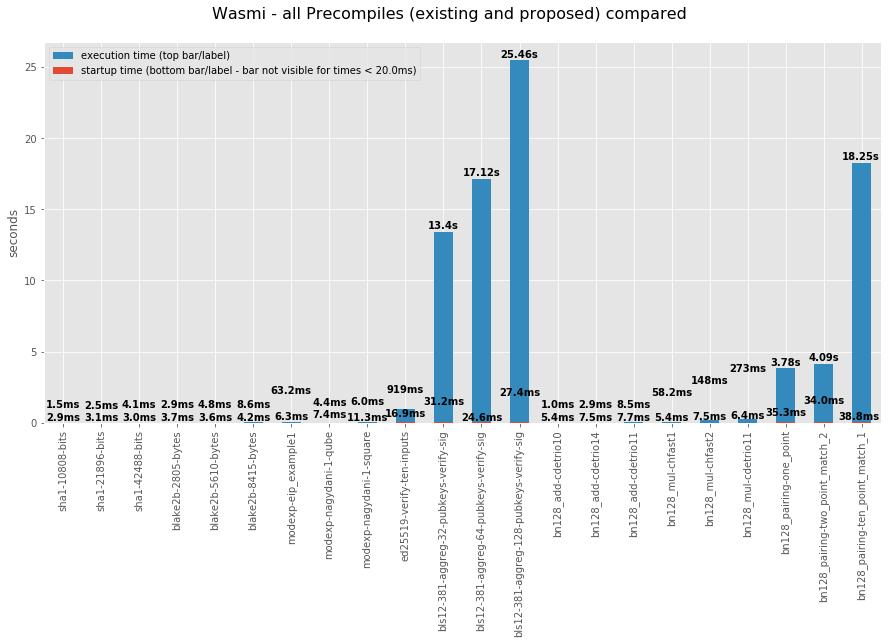

In [69]:
plotInterpOneEngine(df_interp, 'wasmi', all_tests, "Wasmi - all Precompiles (existing and proposed) compared")

<Figure size 432x288 with 0 Axes>

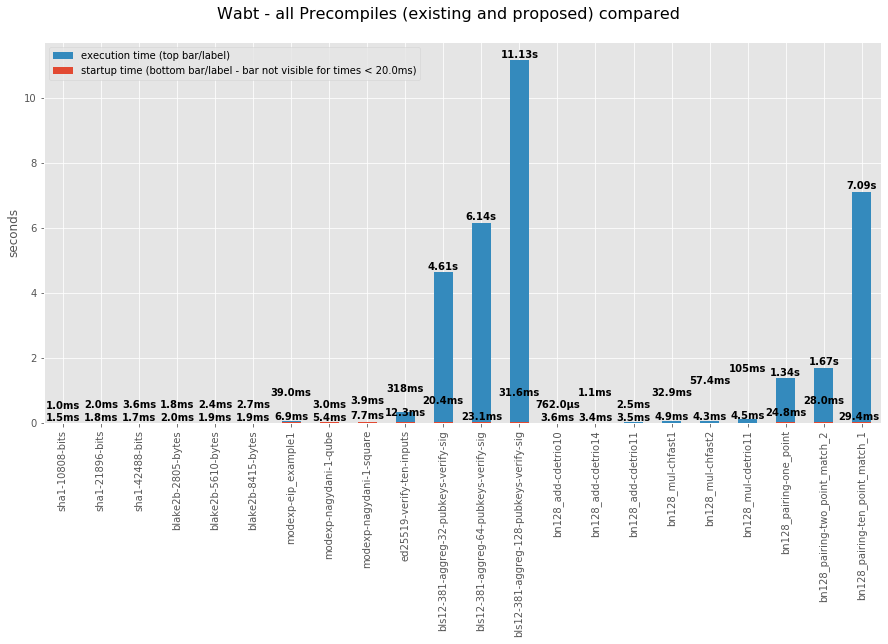

In [70]:
plotInterpOneEngine(df_interp, 'wabt', all_tests, "Wabt - all Precompiles (existing and proposed) compared")